# Heart Disease Prediction Project 


In [89]:
# Importing Libraries
import numpy as np 
import pandas as pd
from sklearn.ensemble import IsolationForest
import seaborn as sns 

The next section Will read the 2 csv files, will merge them into 1 file that will contain the common columns and will remove duplicated data points, in order to cereate the dataset for out project. 

In [17]:
df_1 = pd.read_csv("dataset_1.csv")

In [18]:
df_1.head(3)

,age,sex,chest pain type,resting blood pressure,serum cholestoral,fasting blood sugar,resting electrocardiographic results,max heart rate,exercise induced angina,oldpeak,ST segment,major vessels,thal,heart disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,2
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,1
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,2


In [19]:
df_1.drop(columns=["major vessels","thal"],inplace=True)

In [20]:
df_1['heart disease'] = df_1['heart disease'].replace({2: 1, 1: 0})

In [21]:
# Rename columns of df_1 to match the desired format
df_1.rename(columns={
    'resting blood pressure': 'resting bp s',
    'serum cholestoral': 'cholesterol',
    'fasting blood sugar': 'fasting blood sugar',
    'resting electrocardiographic results': 'resting ecg',
    'ST segment': 'ST slope',
    'heart disease': 'target',
    'exercise induced angina':'exercise angina',
    'sex ': 'sex'
}, inplace=True)

In [22]:
df_1.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,70,1,4,130,322,0,2,109,0,2.4,2,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0
2,57,1,2,124,261,0,0,141,0,0.3,1,1
3,64,1,4,128,263,0,0,105,1,0.2,2,0
4,74,0,2,120,269,0,2,121,1,0.2,1,0


In [23]:
df_2 = pd.read_csv("dataset_2.csv")

In [24]:
df_2.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


**Combining both datasets**

In [25]:
combined_df = pd.concat([df_1, df_2], ignore_index=True)
combined_df.isnull().sum()

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

0 nulls in our dataset.

In [26]:
# Check for duplicated rows
duplicates = combined_df.duplicated()
# Print the number of duplicated rows
print(f'Number of duplicated rows: {duplicates.sum()}')

# Drop the duplicated rows
combined_df = combined_df.drop_duplicates()

# Verify that duplicates are dropped
print(f'Number of rows after dropping duplicates: {combined_df.shape[0]}')

Number of duplicated rows: 542
Number of rows after dropping duplicates: 918


In [27]:
combined_df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,70,1,4,130,322,0,2,109,0,2.4,2,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0
2,57,1,2,124,261,0,0,141,0,0.3,1,1
3,64,1,4,128,263,0,0,105,1,0.2,2,0
4,74,0,2,120,269,0,2,121,1,0.2,1,0


In [28]:
combined_df.to_csv("Concat_Data.csv")

In [29]:
df_backup = combined_df.copy()

# EDA

**From exploring visually, we saw that part of out data contain 0 level of cholesterol, by checking online, this is an impossible scenario. therfore we will use imputation of KNN with median of the 5 NN.** 

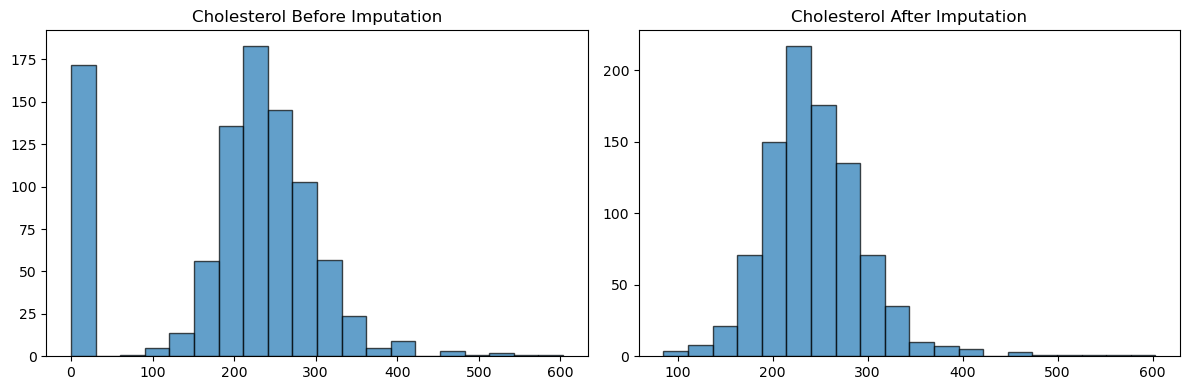

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Assuming combined_df is already loaded as a DataFrame

# Create the first figure for the cholesterol before imputation
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(combined_df['cholesterol'], bins=20, edgecolor='black', alpha=0.7)
plt.title("Cholesterol Before Imputation")

# Replace 0 values in 'cholesterol' temporarily with NaN for KNN imputer
combined_df['cholesterol'].replace(0, np.nan, inplace=True)

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN Imputer on the data
imputed_data = knn_imputer.fit_transform(combined_df)

# Convert imputed data back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=combined_df.columns)

# Rounding the imputed cholesterol values to the nearest integer (optional)
imputed_df['cholesterol'] = imputed_df['cholesterol'].round(0).astype(int)

# Create the second figure for the cholesterol after imputation
plt.subplot(1, 2, 2)
plt.hist(imputed_df['cholesterol'], bins=20, edgecolor='black', alpha=0.7)
plt.title("Cholesterol After Imputation")

plt.tight_layout()
plt.show()


In [31]:
combined_df = imputed_df

# Lets explore outliers using Isolation Forest 

In [32]:
# Assuming combined_df is your DataFrame
# For reproducibility
np.random.seed(42)

# Initialize the model
iso_forest = IsolationForest(contamination=0.03)  # Adjust contamination rate as needed

# Fit the model
iso_forest.fit(combined_df)

# Predict outliers (-1 means outlier, 1 means inlier)
outliers = iso_forest.predict(combined_df)

# Convert predictions to a boolean mask
outlier_mask = outliers == -1

# Number of outliers
num_outliers = np.sum(outlier_mask)
print(f'Number of outliers detected: {num_outliers}')

# Remove outliers from the DataFrame
combined_df = combined_df[~outlier_mask]

# Reset index after dropping rows
combined_df.reset_index(drop=True, inplace=True)

# Verify that outliers are removed
print(f'Number of rows after removing outliers: {combined_df.shape[0]}')


Number of outliers detected: 28
Number of rows after removing outliers: 890


In [33]:
# Value counts for categorical variables
categorical_columns = ['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope', 'target']

for col in categorical_columns:
    print(combined_df[col].value_counts())
    print("----------------------")



1.0    715
0.0    175
Name: sex, dtype: int64
----------------------
4.0    487
3.0    199
2.0    167
1.0     37
Name: chest pain type, dtype: int64
----------------------
0.0    690
1.0    200
Name: fasting blood sugar, dtype: int64
----------------------
0.0    543
1.0    176
2.0    171
Name: resting ecg, dtype: int64
----------------------
0.0    529
1.0    361
Name: exercise angina, dtype: int64
----------------------
2.0    453
1.0    384
3.0     52
0.0      1
Name: ST slope, dtype: int64
----------------------
1.0    495
0.0    395
Name: target, dtype: int64
----------------------


**Conclusion** <br>
Given these characteristics, We decided not to apply additional techniques to balance the 'sex' feature. The tree-based ensemble methods used in our classification task can effectively handle the imbalance through their splitting mechanisms and ensemble effects, ensuring that the predictions remain unbiased and accurate.

**Single features outliers** <br>
in this part we didn't removed any data, we created a boxplot visualization to see ourliers for each specific features. 

Columns with outliers:
- resting bp s
- cholesterol
- max heart rate
- oldpeak


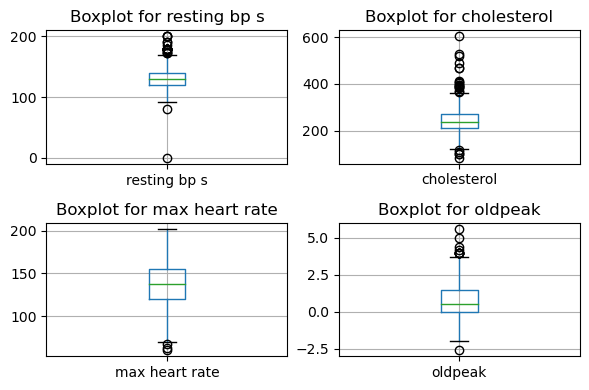

In [34]:
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called 'combined_df'

# Select numerical columns for outlier detection
numerical_columns = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

# Assuming your data is stored in a DataFrame called 'combined_df'
# and numerical columns for outlier detection are specified in 'numerical_columns'

# Define a function for outlier detection using IQR method
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called 'combined_df'
# and numerical columns for outlier detection are specified in 'numerical_columns'

# Define a function for outlier detection using IQR method
def detect_outliers_iqr(data, column, threshold=1.5):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Iterate through numerical columns and detect outliers
outliers_dict = {}
for col in numerical_columns:
    outliers = detect_outliers_iqr(combined_df, col)
    if not outliers.empty:
        outliers_dict[col] = outliers

# Print columns with outliers
if outliers_dict:
    print("Columns with outliers:")
    for col, outliers in outliers_dict.items():
        print(f"- {col}")

    # Show boxplots for columns with outliers in a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(6, 4))
    axes = axes.flatten()
    for i, (col, outliers) in enumerate(outliers_dict.items()):
        combined_df.boxplot(column=col, ax=axes[i])
        axes[i].set_title(f'Boxplot for {col}')
    plt.tight_layout()
    plt.show()
else:
    print("No outliers found in the specified numerical columns.")


# Exploring Data distribution
Distribution of target variable is very important, it will be easier to predict a balanced target variable. 

Text(0.5, 1.0, 'Distribution of Target Variable')

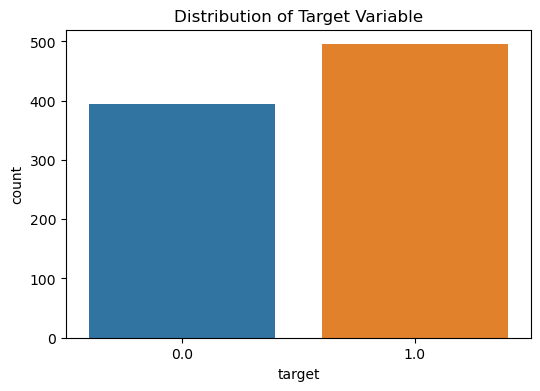

In [35]:
# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=combined_df['target'])
plt.title('Distribution of Target Variable')

**Target Seems to be balanced**

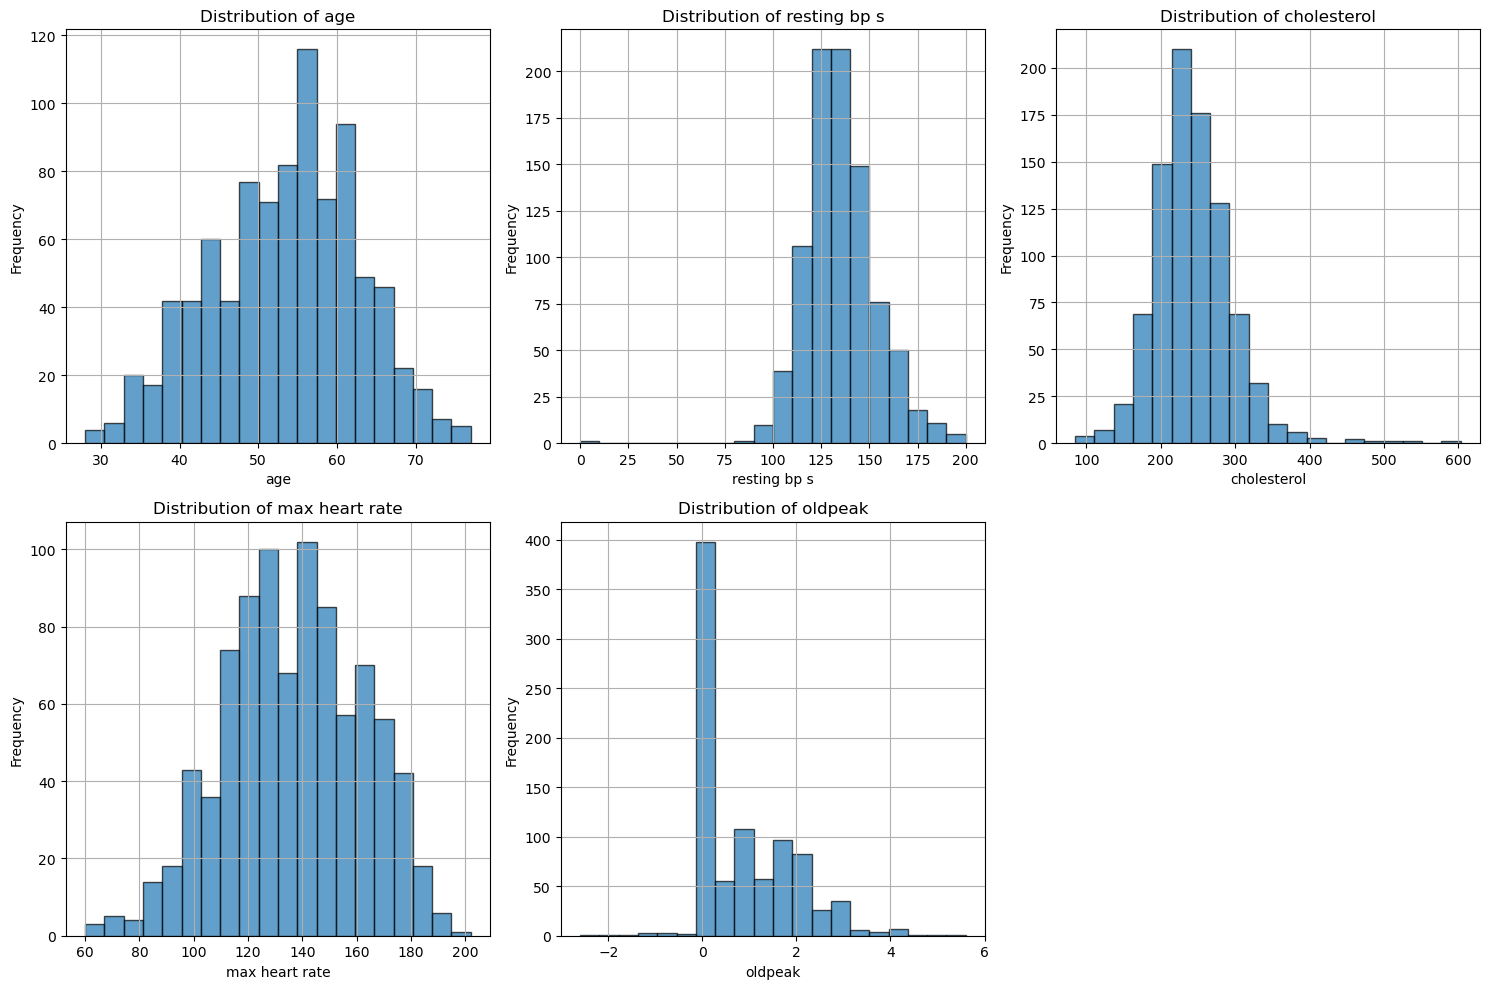

In [36]:
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called 'combined_df'
# and numerical columns for distribution grid are specified in 'numerical_columns'

# Calculate the number of rows and columns for subplots
num_cols = len(numerical_columns)
num_rows = (num_cols + 2) // 3  # Round up to the nearest integer

# Create a 3x3 grid of subplots for numerical columns
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through numerical columns and create histograms
for i, col in enumerate(numerical_columns):
    ax = axes[i]
    ax.hist(combined_df[col], bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Remove any unused subplots
for i in range(num_cols, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("dist.png")
plt.show()


our continious features seems to be normal distributed. except from old peak. 

In [37]:
# Check data types
combined_df.dtypes

age                    float64
sex                    float64
chest pain type        float64
resting bp s           float64
cholesterol              int32
fasting blood sugar    float64
resting ecg            float64
max heart rate         float64
exercise angina        float64
oldpeak                float64
ST slope               float64
target                 float64
dtype: object

In [38]:
# Summary statistics
combined_df.describe().iloc[1:]

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
mean,53.385393,0.803371,3.276404,131.988764,243.565169,0.224719,0.582022,136.659551,0.405618,0.857640,1.624719,0.556180
std,9.315783,0.397673,0.908654,18.083542,52.450338,0.417632,0.792621,25.409533,0.491287,1.028171,0.594932,0.497113
min,28.000000,0.000000,1.000000,0.000000,85.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,211.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,239.000000,0.000000,0.000000,138.000000,0.000000,0.500000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,271.000000,0.000000,1.000000,155.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,5.600000,3.000000,1.000000


# Collinearity Exploration

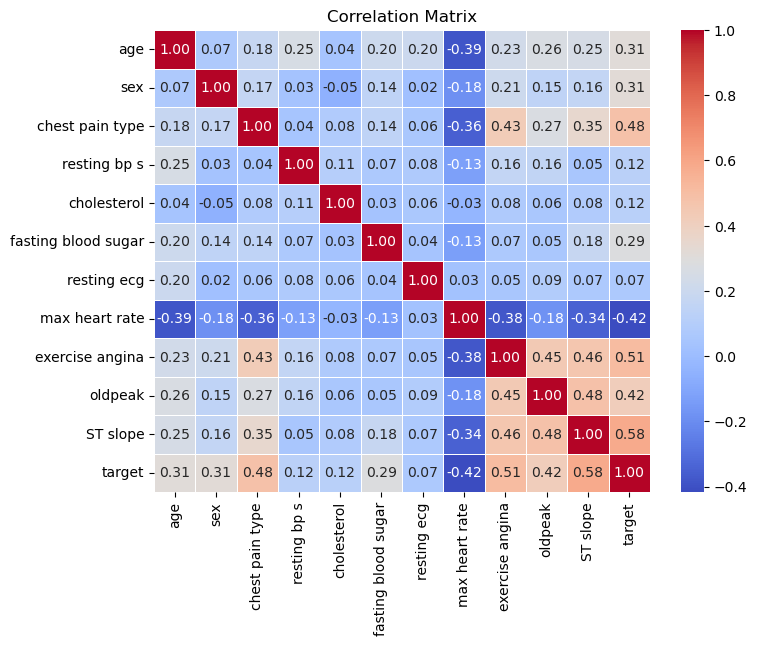

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = combined_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = combined_df.drop('target', axis=1)  # Exclude the target variable
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data.sort_values(by='VIF',ascending=False))


                Feature        VIF
3          resting bp s  48.472047
0                   age  35.805984
7        max heart rate  22.033937
4           cholesterol  21.814693
2       chest pain type  16.828279
10             ST slope  12.600297
1                   sex   5.332519
8       exercise angina   2.730335
9               oldpeak   2.417467
6           resting ecg   1.605951
5   fasting blood sugar   1.390925


By acknowledging the presence of multicollinearity and its potential problems, we can adopt robust machine learning techniques to handle it:
<br> <br> 
* **Regularization techniques such as Ridge and Lasso Regression.**
* **Tree-based models like Random Forest and Gradient Boosting that are less affected by multicollinearity.**
* **Principal Component Analysis (PCA) to transform the feature space.** 
<br> <br>

Using these methods will help ensure that the predictive models are stable, interpretable, and reliable, even in the presence of multicollinearity.

# Model Training 

For models that require extensive hyperparameter tuning, we utilized Grid Search Cross-Validation (Grid Search CV).<br> This technique systematically evaluates a predefined set of hyperparameters to determine the optimal combination that maximizes the model's performance.<br> By exhaustively searching through the parameter grid, Grid Search CV ensures that we explore a wide range of potential configurations.<br> This comprehensive approach not only optimizes the model's performance but also enhances the effectiveness and efficiency of the hyperparameter tuning process.<br> Through this meticulous method, we can confidently select the best-performing model with the most suitable hyperparameters for our specific application.

**Standardize the Data**
**Importance of Standardizing Data**

Data standardization is crucial in machine learning for several reasons:

1. **Equal Scaling**: Standardizing data brings all features to a similar scale, preventing features with larger numerical ranges from dominating the model training process. This ensures that each feature contributes equally to the learning algorithm.

2. **Improved Convergence**: Many machine learning algorithms, such as SVM, KNN, and logistic regression, perform better when features are standardized. Standardization helps these algorithms converge faster, leading to quicker training times.

3. **Better Performance**: Models trained on standardized data often achieve higher performance metrics. Standardization reduces the impact of outliers and makes the model more robust to noisy data.

4. **Required by Some Algorithms**: Certain algorithms assume that data is centered at zero and has a standard deviation of one (e.g., PCA). Failure to standardize data can lead to suboptimal results or even algorithm failure.

5. **Interpretability**: Standardized data is easier to interpret. Coefficients and feature importance values derived from standardized data can be compared directly, providing clearer insights into the model's behavior.



In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split data into features and target
X = combined_df.drop('target', axis=1)
y = combined_df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Apply Ridge Regularization**

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize and fit the Ridge Regression (Logistic Regression with L2 penalty) model
ridge_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
ridge_model.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42, solver='liblinear')

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Assuming ridge_model is already trained with the best parameters
# Make predictions on the training data
y_pred_ridge_train = ridge_model.predict(X_train_scaled)

# Calculate metrics for training data
accuracy_train_ridge = accuracy_score(y_train, y_pred_ridge_train)
precision_train_ridge = precision_score(y_train, y_pred_ridge_train, average='weighted')
recall_train_ridge = recall_score(y_train, y_pred_ridge_train, average='weighted')
f1_train_ridge = f1_score(y_train, y_pred_ridge_train, average='weighted')

# Print the results for training data
print("Ridge Regression (L2) Train Results:")
print(f'Accuracy: {accuracy_train_ridge:.4f}')
print(f'Precision: {precision_train_ridge:.4f}')
print(f'Recall: {recall_train_ridge:.4f}')
print(f'F1-Score: {f1_train_ridge:.4f}')


Ridge Regression (L2) Train Results:
Accuracy: 0.8722
Precision: 0.8720
Recall: 0.8722
F1-Score: 0.8720


In [44]:
# Make predictions on the test data
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Calculate metrics for test data
accuracy_test_ridge = accuracy_score(y_test, y_pred_ridge)
precision_test_ridge = precision_score(y_test, y_pred_ridge, average='weighted')
recall_test_ridge = recall_score(y_test, y_pred_ridge, average='weighted')
f1_test_ridge = f1_score(y_test, y_pred_ridge, average='weighted')

# Print the results for test data
print("\nRidge Regression (L2) Test Results:")
print(f'Accuracy: {accuracy_test_ridge:.4f}')
print(f'Precision: {precision_test_ridge:.4f}')
print(f'Recall: {recall_test_ridge:.4f}')
print(f'F1-Score: {f1_test_ridge:.4f}')


Ridge Regression (L2) Test Results:
Accuracy: 0.8427
Precision: 0.8425
Recall: 0.8427
F1-Score: 0.8425


**Apply Lasso Regularization**

In [45]:
# Initialize and fit the Lasso Regression (Logistic Regression with L1 penalty) model
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso_model.fit(X_train_scaled, y_train)


LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [46]:
# Assuming lasso_model is already trained with the best parameters
# Make predictions on the training data
y_pred_lasso_train = lasso_model.predict(X_train_scaled)

# Calculate metrics for training data
accuracy_train_lasso = accuracy_score(y_train, y_pred_lasso_train)
precision_train_lasso = precision_score(y_train, y_pred_lasso_train, average='weighted')
recall_train_lasso = recall_score(y_train, y_pred_lasso_train, average='weighted')
f1_train_lasso = f1_score(y_train, y_pred_lasso_train, average='weighted')

# Print the results for training data
print("Lasso Regression (L1) Train Results:")
print(f'Accuracy: {accuracy_train_lasso:.4f}')
print(f'Precision: {precision_train_lasso:.4f}')
print(f'Recall: {recall_train_lasso:.4f}')
print(f'F1-Score: {f1_train_lasso:.4f}')

Lasso Regression (L1) Train Results:
Accuracy: 0.8722
Precision: 0.8720
Recall: 0.8722
F1-Score: 0.8720


In [47]:
# Make predictions on the test data
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate metrics for test data
accuracy_test_lasso = accuracy_score(y_test, y_pred_lasso)
precision_test_lasso = precision_score(y_test, y_pred_lasso, average='weighted')
recall_test_lasso = recall_score(y_test, y_pred_lasso, average='weighted')
f1_test_lasso = f1_score(y_test, y_pred_lasso, average='weighted')

# Print the results for test data
print("\nLasso Regression (L1) Test Results:")
print(f'Accuracy: {accuracy_test_lasso:.4f}')
print(f'Precision: {precision_test_lasso:.4f}')
print(f'Recall: {recall_test_lasso:.4f}')
print(f'F1-Score: {f1_test_lasso:.4f}')


Lasso Regression (L1) Test Results:
Accuracy: 0.8371
Precision: 0.8369
Recall: 0.8371
F1-Score: 0.8368


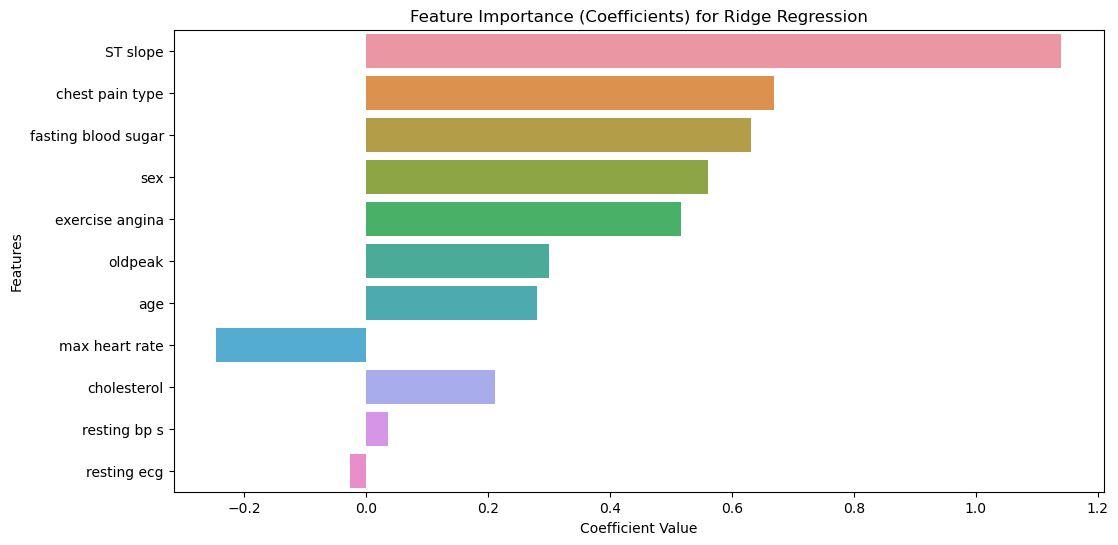

In [48]:
# Assuming ridge_model is already trained
ridge_coefficients = ridge_model.coef_.flatten()
features = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': ridge_coefficients
})

# Sort the DataFrame by the absolute value of the coefficients
feature_importance_df['abs_coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='abs_coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Coefficients) for Ridge Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


Feature importance is crucial because it helps identify which variables most significantly impact the model's predictions.<br> In this Ridge Regression analysis, several features demonstrated higher importance, indicating their strong influence on predicting heart disease.<br> Understanding feature importance aids in improving model interpretability, refining the model by focusing on significant predictors, and potentially guiding data collection efforts towards more impactful variables.<br> This step ensures the model's decisions are based on the most relevant information, enhancing both performance and reliability.

**K Nearest Neighbours**

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
# Define the parameter grid
param_grid = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}


In [50]:
# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize the RandomizedSearchCV with 10-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    cv=10,  # 10-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f'Best parameters found: {best_params}')


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}


In [51]:
# Initialize the KNN classifier with the best parameters
best_knn = KNeighborsClassifier(**best_params)

# Fit the model
best_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='manhattan')

In [52]:
# Make predictions on the training data
y_pred_knn_train = best_knn.predict(X_train_scaled)

# Calculate metrics for training data
accuracy_train_knn = accuracy_score(y_train, y_pred_knn_train)
precision_train_knn = precision_score(y_train, y_pred_knn_train, average='weighted')
recall_train_knn = recall_score(y_train, y_pred_knn_train, average='weighted')
f1_train_knn = f1_score(y_train, y_pred_knn_train, average='weighted')

# Print the results for training data
print("KNN Training Results with Best Hyperparameters:")
print(f'Accuracy: {accuracy_train_knn:.4f}')
print(f'Precision: {precision_train_knn:.4f}')
print(f'Recall: {recall_train_knn:.4f}')
print(f'F1-Score: {f1_train_knn:.4f}')


KNN Training Results with Best Hyperparameters:
Accuracy: 0.9003
Precision: 0.9002
Recall: 0.9003
F1-Score: 0.9002


In [53]:
# Make predictions on the test data
y_pred_knn = best_knn.predict(X_test_scaled)

# Calculate metrics for test data
accuracy_test_knn = accuracy_score(y_test, y_pred_knn)
precision_test_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_test_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_test_knn = f1_score(y_test, y_pred_knn, average='weighted')

# Print the results for test data
print("\nKNN Test Results with Best Hyperparameters:")
print(f'Accuracy: {accuracy_test_knn:.4f}')
print(f'Precision: {precision_test_knn:.4f}')
print(f'Recall: {recall_test_knn:.4f}')
print(f'F1-Score: {f1_test_knn:.4f}')


KNN Test Results with Best Hyperparameters:
Accuracy: 0.8539
Precision: 0.8538
Recall: 0.8539
F1-Score: 0.8537


# SVM

In [54]:
from sklearn.svm import SVC
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Initialize the SVM classifier
svm = SVC()

# Initialize the RandomizedSearchCV with 10-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    cv=10,  # 10-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [55]:
# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42, verbose=1)

In [56]:
random_search.best_params_

{'kernel': 'sigmoid', 'gamma': 0.01, 'C': 10}

In [60]:
from sklearn.metrics import confusion_matrix
# Train the SVM model with the best parameters
best_svm = random_search.best_estimator_
# Make predictions on the training data
y_pred_svm_train = best_svm.predict(X_train_scaled)
# Calculate accuracy for training data
accuracy_train = accuracy_score(y_train, y_pred_svm_train)
# Calculate precision for training data
precision_train = precision_score(y_train, y_pred_svm_train, average='weighted')
# Calculate recall for training data
recall_train = recall_score(y_train, y_pred_svm_train, average='weighted')
# Calculate F1-score for training data
f1_train = f1_score(y_train, y_pred_svm_train, average='weighted')
# Print the training results
print("SVM Training Results:")
print(f'Accuracy: {accuracy_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1-Score: {f1_train:.4f}')

# Compute the confusion matrix for training data
conf_matrix_train = confusion_matrix(y_train, y_pred_svm_train)

SVM Training Results:
Accuracy: 0.8764
Precision: 0.8763
Recall: 0.8764
F1-Score: 0.8762


In [61]:
# Make predictions on the test data
y_pred_svm = best_svm.predict(X_test_scaled)
# Calculate accuracy for test data
accuracy_test = accuracy_score(y_test, y_pred_svm)
# Calculate precision for test data
precision_test = precision_score(y_test, y_pred_svm, average='weighted')
# Calculate recall for test data
recall_test = recall_score(y_test, y_pred_svm, average='weighted')
# Calculate F1-score for test data
f1_test = f1_score(y_test, y_pred_svm, average='weighted')
# Print the test results
print("SVM Test Results:")
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-Score: {f1_test:.4f}')

SVM Test Results:
Accuracy: 0.8371
Precision: 0.8372
Recall: 0.8371
F1-Score: 0.8365


# Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [63]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 10-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=decision_tree,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    cv=10,  # 10-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [64]:
# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\adifro\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
250 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
182 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\adifro\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adifro\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\adifro\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              20]},
                   random_state=42, verbose=1)

In [65]:
# Print the best parameters
best_params = random_search.best_params_
print(f'Best parameters found: {best_params}')
# Train the Decision Tree model with the best parameters
best_decision_tree = random_search.best_estimator_

Best parameters found: {'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None, 'max_depth': 50}


In [66]:
# Make predictions on the training data
y_pred_dt_train = best_decision_tree.predict(X_train_scaled)
# Calculate accuracy for training data
accuracy_train = accuracy_score(y_train, y_pred_dt_train)
# Calculate precision for training data
precision_train = precision_score(y_train, y_pred_dt_train, average='weighted')
# Calculate recall for training data
recall_train = recall_score(y_train, y_pred_dt_train, average='weighted')
# Calculate F1-score for training data
f1_train = f1_score(y_train, y_pred_dt_train, average='weighted')
# Print the training results
print("Decision Tree Training Results:")
print(f'Accuracy: {accuracy_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1-Score: {f1_train:.4f}')

Decision Tree Training Results:
Accuracy: 0.9115
Precision: 0.9124
Recall: 0.9115
F1-Score: 0.9117


In [67]:
# Make predictions on the test data
y_pred_dt = best_decision_tree.predict(X_test_scaled)
# Calculate accuracy for test data
accuracy_test = accuracy_score(y_test, y_pred_dt)
# Calculate precision for test data
precision_test = precision_score(y_test, y_pred_dt, average='weighted')
# Calculate recall for test data
recall_test = recall_score(y_test, y_pred_dt, average='weighted')
# Calculate F1-score for test data
f1_test = f1_score(y_test, y_pred_dt, average='weighted')
# Print the test results
print("Decision Tree Test Results:")
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-Score: {f1_test:.4f}')

Decision Tree Test Results:
Accuracy: 0.8258
Precision: 0.8268
Recall: 0.8258
F1-Score: 0.8261


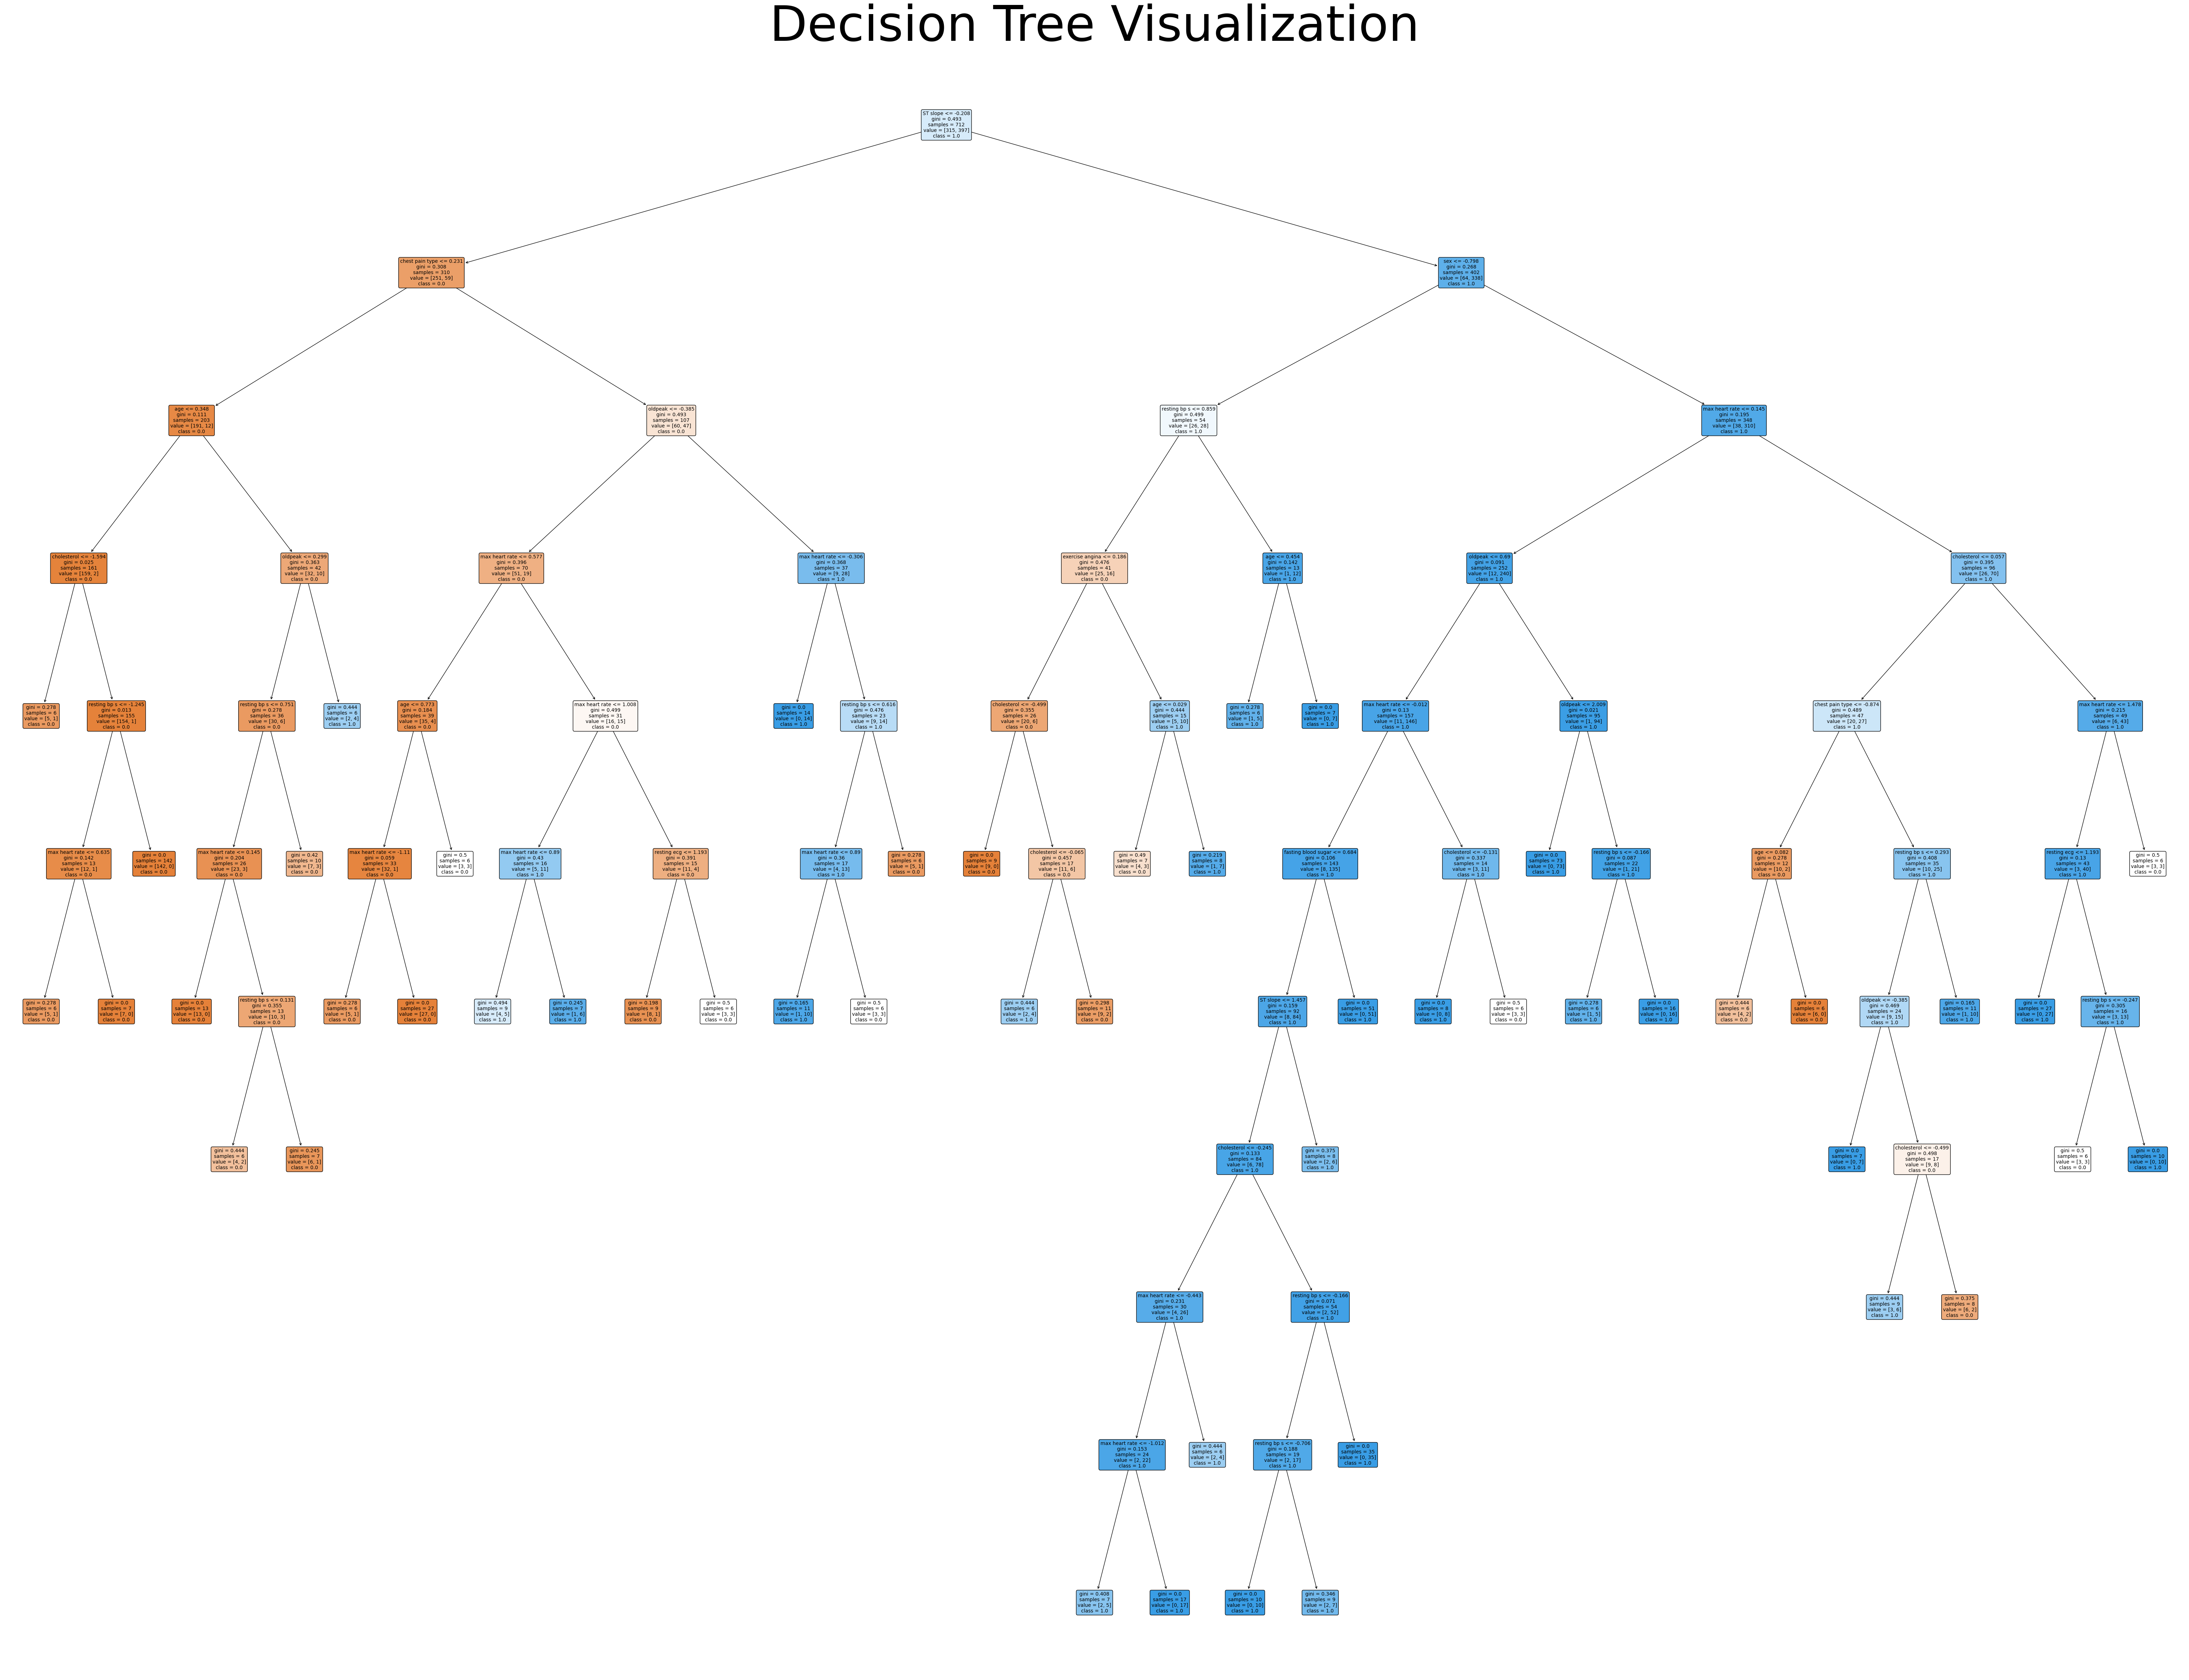

In [87]:
# Visualize the decision tree
plt.figure(figsize=(80, 60))
plot_tree(best_decision_tree, filled=True, feature_names=X_train.columns.tolist(), class_names=np.unique(y_train).astype(str).tolist(), rounded=True)
plt.title('Decision Tree Visualization', fontsize=100)
plt.show()

# Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 10-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    cv=10,  # 10-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [70]:
# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\adifro\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
300 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
121 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\adifro\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adifro\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\adifro\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=1)

In [71]:

# Print the best parameters found
best_params = random_search.best_params_
print(f'Best parameters found: {best_params}')

# Train the Random Forest model with the best parameters
best_random_forest = random_search.best_estimator_


Best parameters found: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40}


In [72]:
# Make predictions on the training data
y_pred_rf_train = best_random_forest.predict(X_train_scaled)

# Calculate accuracy for training data
accuracy_train = accuracy_score(y_train, y_pred_rf_train)

# Calculate precision for training data
precision_train = precision_score(y_train, y_pred_rf_train, average='weighted')

# Calculate recall for training data
recall_train = recall_score(y_train, y_pred_rf_train, average='weighted')

# Calculate F1-score for training data
f1_train = f1_score(y_train, y_pred_rf_train, average='weighted')

# Print the training results
print("Random Forest Training Results:")
print(f'Accuracy: {accuracy_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1-Score: {f1_train:.4f}')


Random Forest Training Results:
Accuracy: 0.9382
Precision: 0.9384
Recall: 0.9382
F1-Score: 0.9381


In [73]:
# Make predictions on the test data
y_pred_rf = best_random_forest.predict(X_test_scaled)

# Calculate accuracy for test data
accuracy_test = accuracy_score(y_test, y_pred_rf)

# Calculate precision for test data
precision_test = precision_score(y_test, y_pred_rf, average='weighted')

# Calculate recall for test data
recall_test = recall_score(y_test, y_pred_rf, average='weighted')

# Calculate F1-score for test data
f1_test = f1_score(y_test, y_pred_rf, average='weighted')

# Print the test results
print("Random Forest Test Results:")
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-Score: {f1_test:.4f}')


Random Forest Test Results:
Accuracy: 0.8483
Precision: 0.8482
Recall: 0.8483
F1-Score: 0.8482


# XGBoost

In [75]:
from xgboost import XGBClassifier, plot_importance
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 10-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    cv=10,  # 10-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)


In [76]:
# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, verbose=1)

In [77]:
# Print the best parameters found
best_params = random_search.best_params_
print(f'Best parameters found: {best_params}')

# Train the XGBoost model with the best parameters
best_xgb = random_search.best_estimator_


Best parameters found: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


In [78]:
# Make predictions on the training data
y_pred_xgb_train = best_xgb.predict(X_train_scaled)

# Calculate accuracy for training data
accuracy_train = accuracy_score(y_train, y_pred_xgb_train)

# Calculate precision for training data
precision_train = precision_score(y_train, y_pred_xgb_train, average='weighted')

# Calculate recall for training data
recall_train = recall_score(y_train, y_pred_xgb_train, average='weighted')

# Calculate F1-score for training data
f1_train = f1_score(y_train, y_pred_xgb_train, average='weighted')

# Print the training results
print("XGBoost Training Results:")
print(f'Accuracy: {accuracy_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1-Score: {f1_train:.4f}')


XGBoost Training Results:
Accuracy: 0.9270
Precision: 0.9271
Recall: 0.9270
F1-Score: 0.9268


In [79]:
# Make predictions on the test data
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Calculate accuracy for test data
accuracy_test = accuracy_score(y_test, y_pred_xgb)

# Calculate precision for test data
precision_test = precision_score(y_test, y_pred_xgb, average='weighted')

# Calculate recall for test data
recall_test = recall_score(y_test, y_pred_xgb, average='weighted')

# Calculate F1-score for test data
f1_test = f1_score(y_test, y_pred_xgb, average='weighted')

# Print the test results
print("XGBoost Test Results:")
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-Score: {f1_test:.4f}')

XGBoost Test Results:
Accuracy: 0.8596
Precision: 0.8607
Recall: 0.8596
F1-Score: 0.8588


<Figure size 1000x800 with 0 Axes>

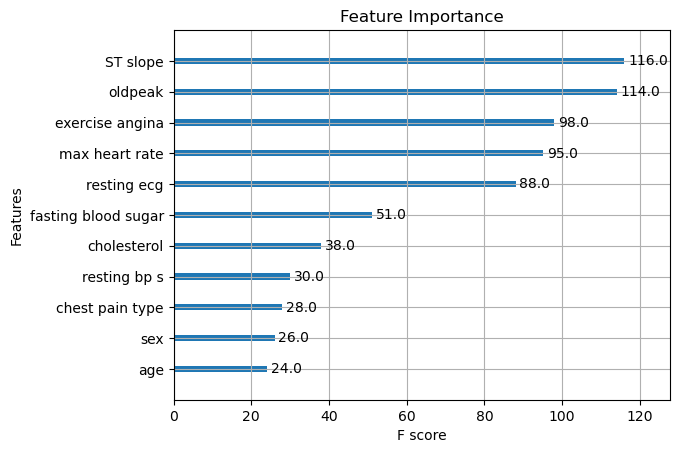

In [80]:
from xgboost import plot_importance
# Store feature names from the original DataFrame
feature_names = X_train.columns.tolist()
# Plot feature importance with proper feature names
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, importance_type='weight', max_num_features=20, title='Feature Importance')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.title('Feature Importance')
plt.show()


# Comparasion

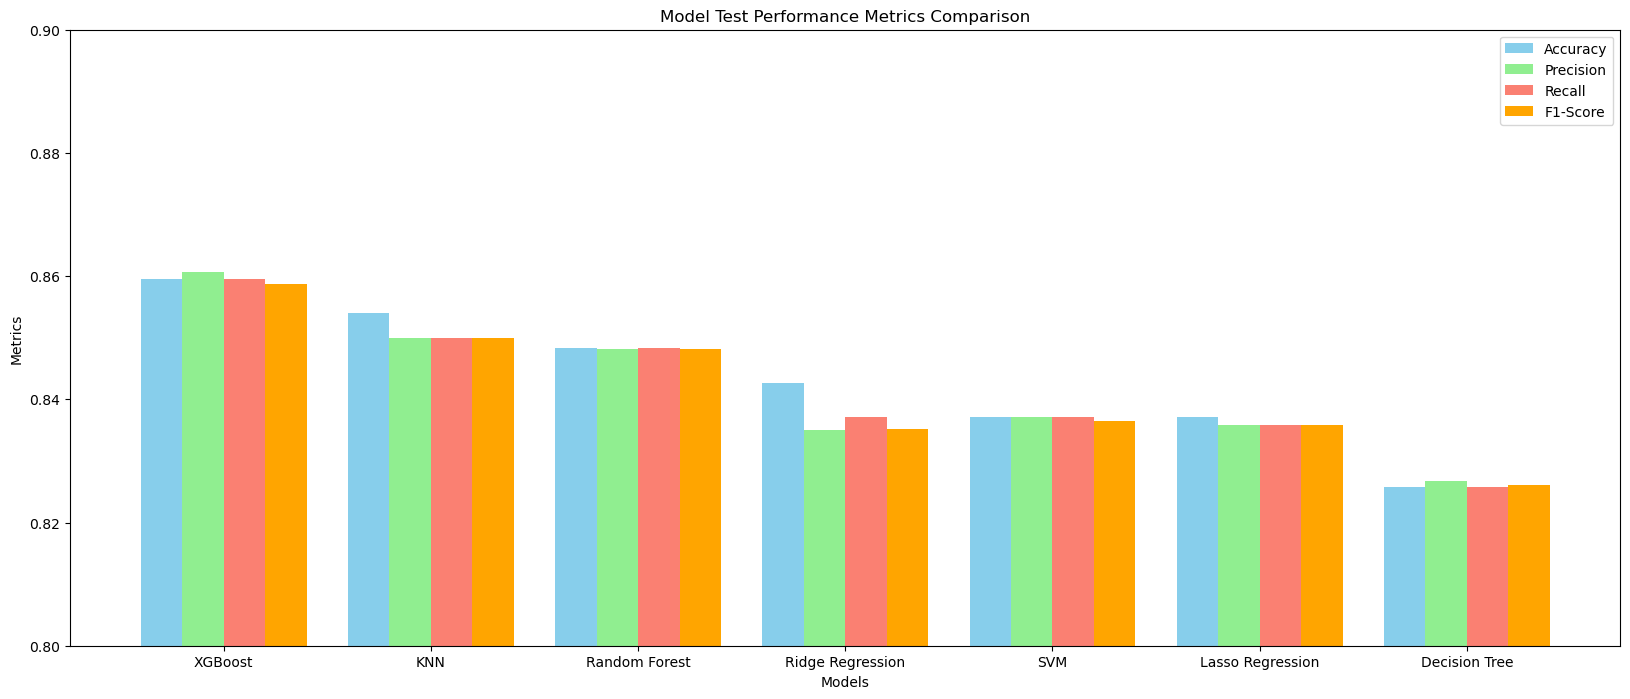

In [83]:
# Data
data = {
    'Model': [
        'XGBoost', 'Random Forest', 'Decision Tree', 
        'SVM', 'KNN', 'Lasso Regression', 'Ridge Regression'
    ],
    'Accuracy': [
        0.8596, 0.8483, 0.8258, 0.8371, 0.8539325842696629, 
        0.8370786516853933, 0.8426966292134831
    ],
    'Precision': [
        0.8607, 0.8482, 0.8268, 0.8372, 0.85, 
        0.835820895522388, 0.8349514563106796
    ],
    'Recall': [
        0.8596, 0.8483, 0.8258, 0.8371, 0.85, 
        0.835820895522388, 0.8370786516853933
    ],
    'F1-Score': [
        0.8588, 0.8482, 0.8261, 0.8365, 0.85, 
        0.835820895522388, 0.8351648351648352
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Sorting by Accuracy as example
df_sorted = df.sort_values(by='Accuracy', ascending=False)

# Plotting
bar_width = 0.2
bar_positions = list(range(len(df_sorted)))

plt.figure(figsize=(20, 8))

# Plot each metric with different colors
plt.bar([pos - 1.5*bar_width for pos in bar_positions], df_sorted['Accuracy'], width=bar_width, label='Accuracy', color='skyblue')
plt.bar([pos - 0.5*bar_width for pos in bar_positions], df_sorted['Precision'], width=bar_width, label='Precision', color='lightgreen')
plt.bar([pos + 0.5*bar_width for pos in bar_positions], df_sorted['Recall'], width=bar_width, label='Recall', color='salmon')
plt.bar([pos + 1.5*bar_width for pos in bar_positions], df_sorted['F1-Score'], width=bar_width, label='F1-Score', color='orange')
plt.ylim(0.8, 0.9)
# Adding the labels
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Test Performance Metrics Comparison')
plt.xticks([pos for pos in bar_positions], df_sorted['Model'])
plt.legend()

plt.show()

Among the models evaluated for heart disease prediction, **XGBoost** stands out with the highest accuracy of 85.96%, precision of 86.07%, recall of 85.96%, and F1-score of 85.88%.<br> **Random Forest** follows closely behind with an accuracy of 84.83%, precision of 84.82%, recall of 84.83%, and F1-score of 84.82%,<br> while **Decision Tree** achieved an accuracy of 82.58%, precision of 82.68%, recall of 82.58%, and F1-score of 82.61%.

**XGBoost** excels due to several reasons:
- **Ensemble Method Advantage**: XGBoost is an ensemble learning method that combines the predictions from multiple decision trees, which often leads to improved predictive performance compared to single models like Decision Trees.
- **Regularization Techniques**: It incorporates regularization techniques to prevent overfitting, which helps generalize well to new data.
- **Gradient Boosting Framework**: XGBoost uses a gradient boosting framework that optimizes the performance metrics by minimizing the loss function gradient.
- **Handling Missing Values**: XGBoost can handle missing data internally, reducing the need for extensive data preprocessing.
- **Scalability**: It is highly scalable, making it suitable for large datasets and complex problems.

In this evaluation, XGBoost's ability to effectively harness the strengths of ensemble methods and its optimization capabilities resulted in superior performance metrics, making it the preferred choice for future predictions in heart disease prediction tasks.
